# FIT 5212 Assignment 2
### Student Name: Han Li
### Student ID: 32710542
### Kaggle ID: HanL/kitcat

In [4]:
# Libraries for data preparation & visualization
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-surprise
# Importing libraries for model building & evaluation
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD,SVDpp
from surprise import accuracy

#Miscellaneous
import os
import random
from surprise.dump import dump,load
# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")
sns.set_style("dark")


In [5]:
#Loading require datas
def dataloading(filename):
    file_path = f"{os.getcwd()}/{filename}.csv"
    df = pd.read_csv(file_path)
    return df 
train  = dataloading('train')
test = dataloading('test')
book_meta = dataloading('books_metadata')

For The recommender system, I will try to train 1 each of content based and collaborate based model, then combining them for a final Hybrid model, the weight will be tested by their validation performance

### Part 2: EDA

#### In this part, I will be looking for some common trend within this dataset.

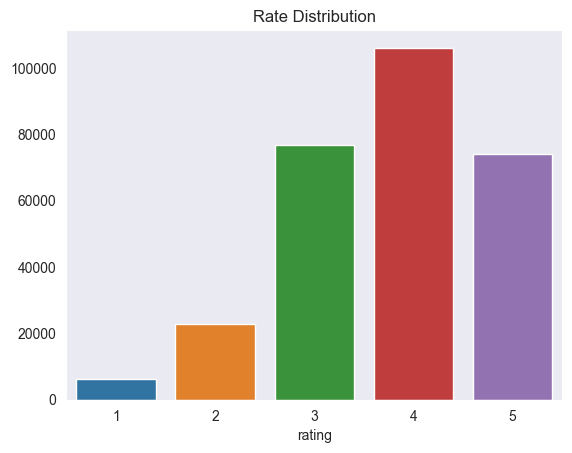

In [6]:
#First, I want to see the trend of rate distribution
#We can start by checking  distribution of the rate, observe the trend
user_rate_dis = train.rating.value_counts()
x,y = user_rate_dis.index,user_rate_dis.values
ax = sns.barplot(x = x,y=y)
plt.title('Rate Distribution')
plt.show()
## User tend to give score between 3 - 5, with 4 be the most common score for a book.

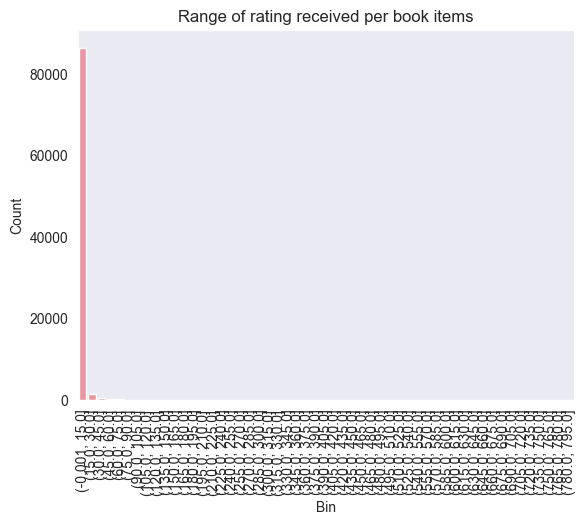

In [7]:
#Then I want to check of how many rating on average received per book
a = train.groupby('book_name').count()['user_id']
bins = pd.cut(a, bins=range(0, max(a), 15), include_lowest=True)
# Count the number of data points in each bin
counts = bins.value_counts(sort=False)
# Create a barplot in seaborn based on the bin counts
ax = sns.barplot(x=counts.index, y=counts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Set the title and axis labels
plt.title('Range of rating received per book items')
plt.xlabel('Bin')
plt.ylabel('Count')
# Show the plot
plt.show()
#The count shows that for the majority of books, the review it received it around 0 - 20

Text(0.5, 1.0, 'Count of rate given per user')

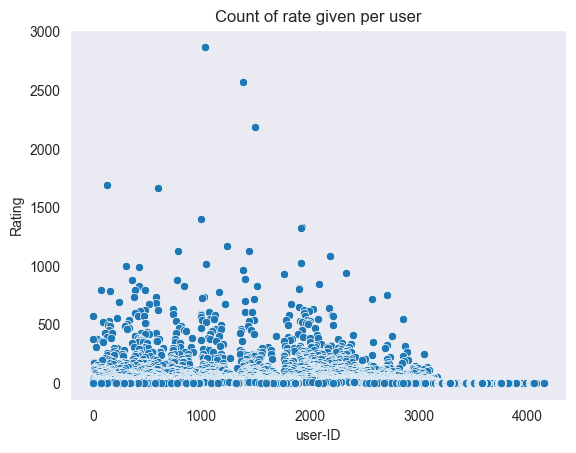

In [17]:
#Then I can visulize on average , how many review will a user give 
user_rating = train.user_id.value_counts().reset_index().rename({'user_id':'user-ID','count':'Rating'}, axis=1)
sns.scatterplot(data = user_rating,x ='user-ID',y= 'Rating')
plt.title('Count of rate given per user')
#From the scatter plot, we notice while many user gived non review, the majority review provide by a user is between 0 - 500, the more extreme value is above 1500

## Data preprocessing

From the EDA session we notice that majority of user whom rated a item will generatlly give a score between 3 to 4. However,Most of the user did not provide much rating where some user contributed over 2500 rating themself.Another finding is that majority of the books only received rating from 0 - 20 users.

Based on EDA's finding, I will introduce the following preprocessing method

1 - Weight up the score '1' 
2 - use only the original dataset
3 - filter out users that provided less than 10 review

## Collaborative filtering

In [18]:
def preprocessing(train_df,book_df,min_book_rating = None,max_user_rating = None,scale = None):
    """
    train_df: training set
    book_df:metadata set
    min_book_rating: selection the minimun number a book has been rated
    max_user_rating: The maximum number a user provided rating
    scale:scale user rating or not
    """
    #train_merged = pd.merge(train_df, book_df, on='item_id').drop('Name',axis = 1)
    train_merged = train
    reader = Reader(rating_scale=(1, 5)) #set up rate scale
    #To construct a full size dataset without any filtering(Method 1)
    if min_book_rating == None and max_user_rating== None and scale == False:
        raw_data = Dataset.load_from_df(train_merged[['user_id', 'item_id', 'rating']], reader)
        raw_rating = raw_data.raw_ratings
        random.shuffle(raw_rating)
        threshold   = int(len(raw_rating)*0.95)
        train_raw_ratings = raw_rating[:threshold] # 80/20 splittion
        val_raw_ratings  = raw_rating[threshold:]
    #Construct a reduce size dataset with filter apply(Method 2)
    else:
        min_book_ratings = min_book_rating
        filter_books = train_merged['book_name'].value_counts() > min_book_ratings
        filter_books = filter_books[filter_books].index.tolist()

        max_user_ratings = max_user_rating
        filter_users = train_merged['user_id'].value_counts() < max_user_ratings
        filter_users = filter_users[filter_users].index.tolist()
        train_data = train_merged[(train_merged['book_name'].isin(filter_books)) & (train_merged['user_id'].isin(filter_users))]
        raw_data = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
        raw_rating = raw_data.raw_ratings
        random.shuffle(raw_rating)
        threshold   = int(len(raw_rating)*0.95)
        train_raw_ratings = raw_rating[:threshold] # 80/20 splittion
        val_raw_ratings  = raw_rating[threshold:]
        for i in range(len(train_raw_ratings)):
            if train_raw_ratings[i][2] == 1:
                train_raw_ratings[i] = (train_raw_ratings[i][0], train_raw_ratings[i][1], train_raw_ratings[i][2] * 2, train_raw_ratings[i][3])

    raw_data.raw_ratings = train_raw_ratings  
    trainset = raw_data.build_full_trainset() 
    valset  = raw_data.construct_testset(val_raw_ratings)
    return trainset,valset,raw_data

In [19]:
trainset,valset,raw_data = preprocessing(train,book_meta,scale =False)
trainset_filter,valset_filter,raw_data_filter = preprocessing(train,book_meta,scale = True ,min_book_rating=2,max_user_rating=1800)

In [20]:
def CV_performance(filter = True):
    """
    full_size: default True. Define whether to perfrom 6 fold CV useing Method 1(full data) or method 2(filtered data)
    """
    models=[KNNBasic(sim_options={'user_base':False}),KNNWithMeans(sim_options={'user_base':False}),KNNWithZScore(sim_options={'user_base':False}),KNNBaseline(sim_options={'user_base':False}),SVD(),SVDpp()]
    results = {}
    CV_scores = None
    if filter == False :
        for model in models:
        # perform 5 fold cross validation
        # evaluation metrics: mean absolute error & root mean square error
            CV_scores = cross_validate(model, raw_data, measures=["MAE","RMSE"], cv=5, n_jobs=-1,verbose = False)  
        
        # storing the average score across the 5 folds cross validation for each model
            result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
                rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
            results[str(model).split("algorithms.")[1].split("object ")[0]] = result
    else:
        for model in models:
        # perform 5 fold cross validation
        # evaluation metrics: mean absolute error & root mean square error
            CV_scores = cross_validate(model, raw_data_filter, measures=["MAE","RMSE"], cv=5, n_jobs=-1,verbose = False)  
        
        # storing the average score across the 5 fold cross validation for each model
            result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
                rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
            results[str(model).split("algorithms.")[1].split("object ")[0]] = result
    performance_df = pd.DataFrame.from_dict(results)
    table = performance_df.T.sort_values(by='MAE')
    return table
        


In [ ]:
print('Without preprocessing')
table = CV_performance(filter = False)
table

In [ ]:
print('With preprocessing')
table = CV_performance(filter = True)
table

It seems for both preprocessing method, the SVDpp provided the best MAE
Following this I will be using a Random search CV to find out the best parameter for both setting

I am also intersting is constrcute a ensemble method so I will construcst a 3 layer model using the top 3 models ie. 

In [ ]:
def train_SVDpp(full_size = True):
    """
    full_size: default True. Define whether to train using Method 1(full data) or method 2(filtered data)
    """
    param_grid_SVDpp = {"n_factors": range(10,500,35),
        'n_epochs': [30,50,110,135,150], 
        'lr_all': [0.002, 0.005,0.007,0.0001,0.0015,0.1,0.01,0.015],
        'reg_all': [0.02, 0.05, 0.1,.75],
        'cache_ratings':[True,False],
        'init_std_dev':[0.1,0.2,0.3],
        'reg_pu':[0.02,0.03,0.05],
        'reg_qi':[0.02,0.03,0.05]}
    randomsearchSVDpp = RandomizedSearchCV(SVDpp, param_grid_SVDpp, measures=['mae','rmse'],
                                            cv=5, n_jobs=-1, n_iter=50)
    if full_size == True:
        randomsearchSVDpp.fit(raw_data)
    else:
        randomsearchSVDpp.fit(raw_data_filter)

        # Get the best MAE score and parameters"
    best_mae_SVDpp = randomsearchSVDpp.best_score['mae']
    best_params_SVDpp = randomsearchSVDpp.best_params['mae']
    return best_mae_SVDpp,best_params_SVDpp

In [ ]:
def train_SVD(full_size=True):
    """
    full_size: default True. Define whether to train useing Method 1(full data) or method 2(filtered data)
    """
    param_grid_SVD = {"n_factors": range(10, 500, 35),
                      'n_epochs': [30,50,110,135,150,200],
                      'lr_all': [0.002, 0.005, 0.007, 0.0001, 0.0015, 0.1, 0.01, 0.015],
                      'reg_all': [0.02, 0.05, 0.1, .75],
                      'init_std_dev': [0.1, 0.2, 0.3],
                      'reg_pu': [0.02, 0.03, 0.05],
                      'reg_qi': [0.02, 0.03, 0.05]}
    randomsearchSVD = RandomizedSearchCV(SVD, param_grid_SVD, measures=['mae', 'rmse'],
                                             cv=5, n_jobs=-1, n_iter=50)
    if full_size == True:
        randomsearchSVD.fit(raw_data)
    else:
        randomsearchSVD.fit(raw_data_filter)

        # Get the best MAE score and parameters
    best_mae_SVD = randomsearchSVD.best_score['mae']
    best_params_SVD = randomsearchSVD.best_params['mae']
    return best_mae_SVD, best_params_SVD


In [ ]:
def train_KNN(full_size = True):
    """
    full_size: default True. Define whether to train useing Method 1(full data) or method 2(filtered data)
    """
    param_grid_KNN = {
                "k": range(1, 15),
                "min_k": [1, 2, 3, 4, 5],
                "sim_options": {
                "name": ["cosine", "pearson"],
                'user_based': [True,False]
                },
                'Verbose':[False]
                }
    randomsearchKNN = RandomizedSearchCV(KNNWithZScore, param_grid_KNN, measures=['mae','rmse'],
                                            cv=5, n_jobs=-1, n_iter=6) #6 iter

    if full_size == True:
        randomsearchKNN.fit(raw_data)
    else:
        randomsearchKNN.fit(raw_data_filter)

        # Get the best MAE score and parameters
    best_mae_KNN = randomsearchKNN.best_score['mae']
    best_params_KNN = randomsearchKNN.best_params['mae']
    return best_mae_KNN,best_params_KNN


In [25]:
def best_model(model,parameter,full_size = True):
    """
    ARGs:

    Model: One of the 3 models to be train using best perfromed parameter
    parameters : best parameter generated from train_XXX function
    full_size: default true, whether to train useing Method 1(full data) or method 2(filtered data)
    """
    if full_size == True: #train 3 model use full size data
        if model == 'SVDpp':
            best_model = SVDpp(**parameter)
        elif model == 'SVD':
            best_model = SVD(**parameter)
        else:
            best_model = KNNWithZScore(**parameter)
        best_model.fit(trainset)
        predictions = best_model.test(valset)
        test_mae = accuracy.mae(predictions)
    else: #train 3 model use reduce size data
        if model == 'SVDpp':
            best_model = SVDpp(**parameter)
        elif model == 'SVD':
            best_model = SVD(**parameter)
        else:
            best_model = KNNWithZScore(**parameter)
        best_model.fit(trainset_filter)
        predictions = best_model.test(valset_filter)
        test_mae = accuracy.mae(predictions)
    return best_model

In [24]:
import time #add timestamp to csv output generated
def ensemble_test(best_model_svd,best_model_svdpp,best_model_KNN,weight,full_size = True):
    """
    ARGs:
    best_model_svd
    best_model_svdpp : The best models that has been fine tune
    best_model_KNN
    weight : a list of 3 float number to add weight to each of the 3 model, the sum of the weight will need to be 1
    full_size: default True. Define what name the .csv output will return.
    """
    test_data = pd.read_csv('test.csv')
    test_predictions = []
    # Define the weights for each model
    weight1 = weight[0]
    weight2 = weight[1]
    weight3 = weight[2]
    for index, row in test_data.iterrows():
        # Get the user and item ID for this row
        user = row['user_id']
        item = row['item_id']

        # Predict each user/item pair
        pred1 = best_model_svd.predict(user, item).est
        pred2 = best_model_svdpp.predict(user, item).est
        pred3 = best_model_KNN.predict(user, item).est
        # Apply weight to each model
        weighted_pred1 = pred1 * weight1
        weighted_pred2 = pred2 * weight2
        weighted_pred3 = pred3 * weight3

        weighted_sum = int(weighted_pred1 + weighted_pred2 + weighted_pred3) # Sum up prediction and round to int

        # Append the weighted sum to the list of test predictions
        test_predictions.append(weighted_sum)

    # Add the list of test predictions as a new column in the test_data DataFrame
    test_data['rating'] = test_predictions
    if full_size:
        # Save the DataFrame to a CSV file
        test_data[['ID', 'rating']].to_csv(f'test_ensemble_weighted{time.time()}.csv', index=False)
    else:
        test_data[['ID', 'rating']].to_csv(f'test_ensemble_weighted_sample{time.time()}.csv', index=False)
    return test_data



In [55]:
def recommendations(df,user_id= None, book_name =None):
    # Provide recommendation to user based on their user id
    if user_id is not None:
        # Filter the test_data DataFrame for recommendations specific to the given user_id
        recommendations = df[df['user_id'] == user_id][['rating','book_name']]
        recommendations = recommendations.sort_values(by='rating', ascending=False)
        return recommendations
    
    # Provide recommendation for user based on book_name
    if book_name is not None:
        book_id = df[df['book_name'] == book_name]['item_id'].iloc[0]
        recommendations = df[df['item_id'] == book_id][['user_id', 'rating']]
        recommendations = recommendations.sort_values(by='rating', ascending=False)
        return recommendations
    


In [46]:
book_meta[book_meta['item_id'] == 2330]['Name']

,Name,pagesNumber,Publisher,CountsOfReview,PublishYear,Language,Authors,Rating,item_id
2350,On Beauty,445.0,Penguin Books,3686,2006,eng,Zadie Smith,3.73,2330.0


In [ ]:
#Look up best parameter for downsize model - around 60min runtime
best_mae_SVD,best_params_SVD = train_SVD(full_size=False)
best_mae_SVDpp,best_params_SVDpp = train_SVDpp(full_size=False)
best_mae_KNN,best_params_KNN = train_KNN(full_size=False)

In [ ]:
#Look up best parameter for fullsize model - around 7-8hr run times
best_mae_SVD_FULL,best_params_SVD_FULL = train_SVD(full_size=True)
best_mae_SVDpp_FULL,best_params_SVDpp_FULL = train_SVDpp(full_size=True)
best_mae_KNN_FULL,best_params_KNN_FULL = train_KNN(full_size=True)

Copy of the best parameters
best_params_SVD_FULL{'n_factors': 430, 'n_epochs': 50, 'lr_all': 0.015, 'reg_all': 0.05, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_SVDpp_FULL{'n_factors': 395, 'n_epochs': 50, 'lr_all': 0.015, 'reg_all': 0.02, 'cache_ratings': False, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_KNN_FULL{'k': 13, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': False}, 'Verbose': False}
best_params_SVD{'n_factors': 45, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.02, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_SVDpp{'n_factors': 45, 'n_epochs': 50, 'lr_all': 0.0015, 'reg_all': 0.02, 'cache_ratings': True, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.02}
best_params_KNN{'k': 10, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}, 'Verbose': False}

In [22]:
#The above code takes around 24hrs to run, and I saved the parameter for reference
best_params_SVD_FULL={'n_factors': 430, 'n_epochs': 650, 'lr_all': 0.0015, 'reg_all': 0.05, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_SVDpp_FULL={'n_factors': 395, 'n_epochs': 150, 'lr_all': 0.015, 'reg_all': 0.02, 'cache_ratings': True, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_KNN_FULL={'k': 15, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}, 'Verbose': False}
best_params_SVD={'n_factors': 45, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.02, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.05}
best_params_SVDpp={'n_factors': 45, 'n_epochs': 50, 'lr_all': 0.0015, 'reg_all': 0.02, 'cache_ratings': True, 'init_std_dev': 0.1, 'reg_pu': 0.03, 'reg_qi': 0.02}
best_params_KNN={'k': 15, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}, 'Verbose': False}

In [26]:
#Downsize Model
best_model_SVD = best_model(model = 'SVD',parameter=best_params_SVD,full_size = False)
best_model_SVDpp = best_model(model = 'SVDpp',parameter=best_params_SVDpp,full_size = False)

MAE:  0.7018
MAE:  0.7003


In [27]:
best_model_KNN = best_model(model = 'KNN',parameter=best_params_KNN,full_size = False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7154


In [29]:
#Train the ensemble downsize model and evaluate its performance
test_data = ensemble_test(best_model_SVD,best_model_SVDpp,best_model_KNN,weight = [.6,.25,.15],full_size = False)

In [36]:
test_data['book_name'][5]

'The BFG'

In [37]:
book_id = test_data[test_data['book_name'] == test_data['book_name'][5]]['item_id'].iloc[0]
recommendations = test_data[test_data['item_id'] == book_id][['user_id', 'rating']]
recommendations = recommendations.sort_values(by='rating', ascending=False)

In [ ]:
best_model_SVD_FULL = best_model(model = 'SVD',parameter=best_params_SVD_FULL,full_size = True)

In [ ]:
best_model_SVDpp_FULL= best_model(model = 'SVDpp',parameter=best_params_SVDpp_FULL,full_size = True)

In [ ]:
best_model_KNN_FULL = best_model(model = 'KNN',parameter=best_params_KNN_FULL,full_size = True)

In [ ]:
#Train the model using full size data
ensemble_test(best_model_SVD_FULL,best_model_SVDpp_FULL,best_model_KNN_FULL,weight = [.2,.65,.15],full_size = True)

In [72]:
# Test using downsize dataset, using user 96 as example
recommendations(df = test_data,user_id = 96)

,rating,book_name
1661,4,Pride and Prejudice
1662,4,The Submission
1664,4,The Long Walk: The True Story of a Trek to Fre...
1663,3,The Five People You Meet in Heaven


In [73]:
train[train['user_id'] == 96].sort_values('rating',ascending=False)

,user_id,item_id,rating,book_name
8117,96,3164,5,Naked
8119,96,5464,5,He's Just Not That Into You: The No-Excuses Tr...
8121,96,2228,5,It's Not about the Bike: My Journey Back to Life
8123,96,996,5,Atlas Shrugged
8124,96,451,5,Me Talk Pretty One Day
8126,96,351,5,"Ender's Game (Ender's Saga, #1)"
8127,96,230,5,The Kite Runner
8128,96,24,5,Freakonomics: A Rogue Economist Explores the H...
8118,96,5463,4,Don't Get Too Comfortable: The Indignities of ...
8120,96,4,4,"The Hunger Games (The Hunger Games, #1)"
